# Toxicity (a Hack6 Project)

## Text Log

In [ ]:
# install necessary packages if it's not already installed
!pip install cohere
!pip install twilio
!pip install translate

# note: these are packages used in the `twitter_util.py` file
!pip install tweepy
!pip install tqdm  # progress bar package

In [1]:
import pandas as pd
import numpy as np
import cohere
from cohere.classify import Example

In [2]:
csv_file = pd.read_csv("Cohere Examples.csv")

In [3]:
examples = []
for index, row in csv_file.iterrows():
    examples.append(Example(csv_file.at[index, "Tweet"], csv_file.at[index, "Sentiment"]))

In [4]:
API_KEY = placeholder_key
co = cohere.Client(API_KEY)

In [5]:
# testing cohere algorithm
response = co.classify(
  model='medium',
  taskDescription='',
  outputIndicator='',
  inputs=["Lmao you suck", "Nice Good Job!", "lmao why are you even posting this", "XD", 'Bruh', 'Wow Cant Wait'],
  examples=examples)

for i in response.classifications:
    print(i.prediction)

Negative
Positive
Negative
Negative
Negative
Positive


In [6]:
# convert txt to dictionary given the filepath of the txt
def convert_txt(filepath):
    txt = open(filepath, "r")
    # dictionary where key is the user and value is a list of messages the user sent during the inputted conversation
    user_messages = {}
    try:
        for line in txt:
            line = line.strip()
            user, message = line.split(":")[0], line.split(":")[1]
            if user in user_messages:
                user_messages[user].append(message)
            else:
                user_messages[user] = [message]
        return user_messages
    
    # txt not in correct format
    except Exception as e:
        print('Please format the txt file in the following format: Username: Message')
        return {}

In [7]:
# given a txt file of the conversation return a dictionary where the key is the user and the value is a list of the sentiments
# of all messages
def classify_conversation(filepath):
    conversation = convert_txt(filepath)
    # if txt is empty or not formatted correctly 
    if not conversation:
        return []
    
    # dict where key is user and value is a list of the sentiment of each message the user sent
    user_evaluation = {}
    for user in conversation:
        user_evaluation[user] = response_classification(conversation[user])
    
    return user_evaluation

In [8]:
# function which takes in a phrase and returns the sentiment in the format of a list 
def response_classification(phrase):
    if type(phrase) == str:
        phrase = [phrase]
        
    response = co.classify(
      model='medium',
      taskDescription='',
      outputIndicator='',
      inputs=phrase,
      examples=examples)
    
    output = []
    for sentiment in response.classifications:
        output.append(sentiment.prediction)
    
    return output

In [9]:
# test inputting txt as convo 
print(classify_conversation('Cohere Test.txt'))

{'Person1': ['Positive', 'Negative', 'Negative'], 'Person2': ['Positive', 'Negative']}


In [9]:
def get_text_toxicity(filepath):
    '''Defines the toxicity of users in the `filepath` conversation using a simple average of sentiment.
    The average is binary (1 being completely toxic and 0 being completely not toxic), computed over
    individual sentiment classifications (1 is negative, 0 is positive). For example, 2 negatives and 1
    positive phrase would result in 2/3 = 0.67
    
    The return type is a dictionary with {key: value} pair being {name_of_person: toxicity_level}'''
    conversation_classification = classify_conversation(filepath)
    for k, v in conversation_classification.items():
        toxicity_score = np.average([1 if sentiment == 'Negative' else 0 for sentiment in v])
        conversation_classification[k] = toxicity_score
    return conversation_classification

In [11]:
# test
get_text_toxicity('Cohere Test.txt')

{'Person1': 0.6666666666666666, 'Person2': 0.5}

## Twitter

### User

In [10]:
# when we're done with development, it's good form to change the import statement from everything (*) to only the 
# functions we need to use
# from twitter_util import get_tweets, get_followers_tweets <-- need to add more

from twitter_util import *

In [13]:
espn_tweets = get_tweets('ESPN', 5)

In [14]:
espn_tweets

{'2022-8-21': ['RT @espnmma: Nothing but respect between Aldo and Dvalishvili 👏 #UFC278 https://t.co/kc7JTbp11H',
  'Chelsea Gray had a hand in 46 of the Aces 117 points 😳 @cgray209 https://t.co/h8QDuyjBO0',
  'The @LVAces are advancing in the #WNBAPlayoffs after a DOMINANT 117-80 win against Phoenix 😤 \n\n#ThatsaW https://t.co/uTAFcT7xS8',
  'Casual push-up contest between the Gronks 💪 \n\nStream #UFC278 with The Gronks NOW on @ESPNPlus ➡️ https://t.co/kLyGQAw3pk https://t.co/6VTa5kZPaa',
  'Paddy Pimblett says he put on 50 pounds in three weeks 😮 #UFC278 https://t.co/p6Z0Pttb18']}

In [11]:
def compute_toxicity_score(tweets, return_num_tweets=False):
    '''
    Given a Twitter dictionary of `tweets` in the form {date: [list of tweets]}, return the average sentiment (classify
    each tweet as positive (0) or negative (1) and then find the average).
    
    If the `return_num_tweets` flag is True, this function returns both the toxicity score (i.e. average sentiment) and the
    number of tweets.
    '''
    sentiments = []
    for tweet in list(tweets.values()):
        for response_class in response_classification(tweet):
            sentiment = 1 if response_class == 'Negative' else 0
            sentiments.append(sentiment)
    if return_num_tweets is False:
        return np.average(sentiments)
    else:
        return np.average(sentiments), len(sentiments)

In [12]:
def get_twitter_toxicity(username, num_tweets):
    '''Defines a certain twitter user with `username`'s toxicity based on the previous `num_tweets` tweets using simple
    average of sentiment. The average is binary (1 being completely toxic and 0 being completely not toxic), computed over
    individual sentiment classifications (1 is negative, 0 is positive).'''
    tweets = get_tweets(username, num_tweets)
    return compute_toxicity_score(tweets)

In [ ]:
get_twitter_toxicity('ESPN', 10)

In [ ]:
get_twitter_toxicity('cobraatateg', 10)
# other examples I tried (was cool just to see)
# get_twitter_toxicity('POTUS', 10)
# get_twitter_toxicity('KSI', 10)

### Followers

In [ ]:
# try it out for ESPN before making a general function
espn_followers_tweets = get_followers_tweets('ESPN', 10, num_followers=25, progress=True)

In [ ]:
espn_followers_tweets

In [13]:
def calculate_weighted_toxicity(tweets, return_data=False):
    '''
    Accept a dictionary of {username: dict({date: [list of tweets]})} (like `espn_followers_tweets` above) and calculate
    the toxicity score as follows:
    
    1. if the follower has no tweets, ignore them
    2. for each follower, find their average sentiment score over their tweets * number of tweets (I call this the
    weighted_val)
    3. To find the final score, take sum(weighted_val) / number of tweets
    
    This is basically a weighted average (i.e. in the case that one person tweets three times and another once, the
    person that tweets 3 times will have their toxicity score be 3 times more important). Another way to think about it
    is that we are effectively taking the average over all tweets treated individually (i.e. it doesn't matter who tweets
    them), but we do it like this for now in case the info is useful later.
    '''
    follower_toxicities = {}
    all_toxicities = []
    for k, v in tqdm(tweets.items()):
        if v is None:
            continue
        if len(v) == 0:  # if the follower has not tweeted at all
            follower_toxicities[k] = (0, 0)  # NOTE: this can be changed later just added it to make sure the UI works
            continue
        toxic_score, num_tweets = compute_toxicity_score(v, return_num_tweets=True)
        for _ in range(num_tweets):
            all_toxicities.append(toxic_score)

    if len(all_toxicities) == 0:
        return 0
        
    if return_data is False:
        try:
            return np.average(all_toxicities)
        except:
            return 0
    
    try:
        return np.average(all_toxicities), all_toxicities
    except:
        return 0, []

In [14]:
def get_followers_avg_toxicity(username, num_tweets_per_follower, num_followers):
    '''Wrapper function that just gets the toxicity score for a user's followers'''
    tweets = get_followers_tweets(username, num_tweets_per_follower, num_followers=num_followers, progress=True)
    return calculate_weighted_toxicity(tweets)

In [15]:
def get_followers_toxicity(username, num_tweets_per_follower, num_followers, return_data=False):
    tweets = get_followers_tweets(username, num_tweets_per_follower, num_followers=num_followers, progress=True)
    avg_toxicity = calculate_weighted_toxicity(tweets, return_data=return_data)
    user_toxicity = {}
    for follower in tweets:
        user_toxicity[follower] = calculate_weighted_toxicity({follower: tweets[follower]})
    user_toxicity = dict(sorted(user_toxicity.items(), key=lambda item: item[1], reverse=True))
    return user_toxicity, avg_toxicity

In [20]:
# this might take a while to run, if so, consider changing the num_followers from 100 to something smaller
espn_followers_tox = get_followers_toxicity('ESPN', 10, 100)

 77%|███████▋  | 77/100 [00:20<00:05,  4.20it/s]

Unable to translate
Unable to translate


 48%|████▊     | 15/31 [00:00<00:00, 17.97it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\rupei\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-9e4f268dd979>", line 2, in <module>
    espn_followers_tox = get_followers_toxicity('ESPN', 10, 100)
  File "<ipython-input-19-67ae04c9c0d3>", line 3, in get_followers_toxicity
    avg_toxicity = calculate_weighted_toxicity(tweets, return_data=return_data)
  File "<ipython-input-17-12682243dc46>", line 24, in calculate_weighted_toxicity
    toxic_score, num_tweets = compute_toxicity_score(v, return_num_tweets=True)
  File "<ipython-input-15-dc175147cccc>", line 11, in compute_toxicity_score
    for response_class in response_classification(tweet):
  File "<ipython-input-8-3ff88c362a60>", line 6, in response_classification
    response = co.classify(
  File "c:\users\rupei\appdata\local\programs\python\python38\lib\site-packages\cohere\cl

KeyboardInterrupt: 

In [ ]:
# this cell seems to take a really long time to run... consider skipping it (this was just something cool I wanted to try)
# get_followers_toxicity('cobraatateg', 10, 100)

### Following (A lot of code is reused!)

In [16]:
def get_following_avg_toxicity(username, num_tweets_per, num_following):
    '''Wrapper function that just gets the toxicity score for a user's following. Note: there is a bug in this and the
    follower wrapper. If somebody has no followers/following, it will throw a divide by 0 (I'll fix this later!)'''
    tweets = get_following_tweets(username, num_tweets_per, num_following=num_following, progress=True)
    return calculate_weighted_toxicity(tweets)

In [17]:
def get_following_toxicity(username, num_tweets_per_follower, num_following, return_data=False):
    tweets = get_following_tweets(username, num_tweets_per_follower, num_following=num_following, progress=True)
    avg_toxicity = calculate_weighted_toxicity(tweets, return_data=return_data)
    user_toxicity = {}
    for following in tweets:
        user_toxicity[following] = calculate_weighted_toxicity({following: tweets[following]})
    user_toxicity = dict(sorted(user_toxicity.items(), key=lambda item: item[1], reverse=True))
    return user_toxicity, avg_toxicity

In [ ]:
espn_following_tox = get_following_toxicity('ESPN', 10, 100)

In [18]:
# get toxicity score for a single user
def get_user_toxicity(username, num_tweets_per):
    tweets = {username: get_tweets(username, num_tweets_per)}
    if tweets == {username: None}:
        return -1
    return calculate_weighted_toxicity(tweets)

In [ ]:
get_following_toxicity('ESPN', 5, 5)

In [ ]:
get_followers_toxicity('ESPN', 5, 5)

In [ ]:
get_user_toxicity('RoyZ1017', 5)

### Statistical Inference

Step 1: With given information, calculate the confidence bounds (number for true level of toxicity)

Step 2: With given information, graph the Bayesian posterior

In [32]:
espn_followers_tox = get_followers_toxicity('ESPN', 10, 100, return_data=True)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [20]:
espn_followers_tox

({'bentmcnugget': 1.0,
  'kissureal': 0.7777777777777778,
  'LudlowBrennon': 0,
  'Adamnothing5': 0,
  'NewZiadAhmed': 0,
  'Faisalk62729931': 0,
  'Black_Beard_01': 0,
  'Diablo848546191': 0,
  'BlancaC93725664': 0,
  'NateAle21': 0,
  'CoreyWa29482397': 0,
  'janghoj68957046': 0,
  'MentusObasi': 0,
  'ogjpuigepoep': 0,
  'Helmyfloyd81': 0,
  'ligayaparsons1': 0,
  'tylercolew84': 0,
  'zhongqinglvmao': 0,
  'samakood': 0,
  'ofifif16': 0,
  'MdKhors82723622': 0,
  'jidaidinzhen': 0,
  'B8llHellen': 0,
  'JAdonte55': 0,
  'bryan_borbas': 0,
  'Jacob10719691': 0,
  'BkFeria': 0,
  'LamarWa52': 0,
  'yaokil': 0,
  'ItachiU08615598': 0,
  'CalebAkin6': 0,
  'xdrcod': 0,
  'A1809dama': 0,
  'Joeysmith221087': 0,
  'Joker2318571636': 0,
  'Lengko1Silfanus': 0,
  'OmbeniPacifiqu1': 0,
  'Nazaren85840222': 0,
  'pierremcdowell7': 0,
  'Dilwale143528': 0.0,
  'AngelCa91553438': 0,
  'SMacintosch': 0,
  'aleekha40769406': 0,
  'Yk_Mil3s': 0,
  'zohaib_raja1122': 0,
  'IssaPlato': 0,
  'nickki

In [33]:
espn_followers_dict, (espn_followers_tox_val, espn_followers_vals) = espn_followers_tox

In [34]:
import scipy.stats as st

def calculate_toxicity_ci(toxicities, confidence=0.95):
    # followers_val is the list of all toxicities (i.e [0.5, 0.5])
    # NOTE: this creates a confidence interval
    return st.t.interval(
        alpha=confidence,
        df=len(toxicities) - 1,
        loc=np.mean(toxicities),
        scale=st.sem(toxicities))

In [35]:
calculate_toxicity_ci(espn_followers_vals, confidence=0.95)

(0.21870175892703558, 0.3378199802033992)

In [36]:
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_bayesian_posterior(toxicities, target_score, prior='uniform'):
    num_toxic = np.arange(0, len(toxicities) + 1, 1)
    toxic_score = np.arange(0, 1.01, 0.01)
    toxic_df = pd.DataFrame([(x, y) for x in num_toxic for y in toxic_score])
    toxic_df.columns = ['num_toxic', 'toxic_score']
    
    if prior == 'uniform':
        toxic_df['prior'] = 1
    else:
        raise ValueError
    
    toxic_df['likelihood'] = binom.pmf(toxic_df.num_toxic, len(toxicities), toxic_df.toxic_score)
    toxic_df['posterior_prob'] = toxic_df.prior * toxic_df.likelihood
    toxic_df.posterior_prob /= toxic_df.posterior_prob.sum()
    
    implied_num_toxic = round(target_score * len(toxicities))
    toxic_df_w_score = toxic_df[toxic_df['num_toxic'] == implied_num_toxic]
    sns.lineplot(toxic_df_w_score.toxic_score, toxic_df_w_score.posterior_prob)
    plt.title("Posterior Probability for Toxicity Score of {}".format(round(target_score, 2)))
    plt.xlabel("Toxic Score")
    plt.ylabel("Posterior Probability")
    plt.show();
    
    return toxic_df_w_score

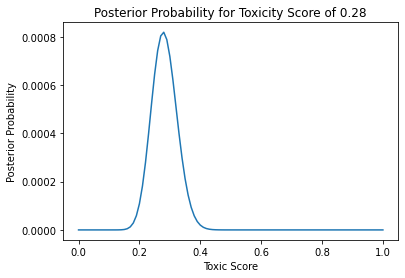

In [37]:
df = calculate_bayesian_posterior(espn_followers_vals, espn_followers_tox_val)

### Twilio API Endpoint


A couple of notes:

1. the from phone number has to be the number below
2. the to phone number has to be my phone number (the one below)

Hence, it can be hard to test this. I'll make this work with our project but for now it seems like maybe we'll just use Twilio to send a text notification if they're talking to somebody Toxic

In [21]:
# NOTE: this is all starter code from https://www.twilio.com/docs/sms/quickstart/python

# Download the helper library from https://www.twilio.com/docs/python/install
import os
from twilio.rest import Client


# Find your Account SID and Auth Token at twilio.com/console
# and set the environment variables. See http://twil.io/secure
account_sid = placeholder_key
auth_token = placeholder_key
client = Client(account_sid, auth_token)

message = client.messages \
                .create(
                     body="You are Toxic!",
                     from_='+18573922329',  # this is a test Twilio phone number
                     to='+15109449884'
                 )

print(message.sid)

SMe8225db5f2ad26a140e9d926ecb1840c


In [22]:
def send_twilio_alert(to, message):
    account_sid = placeholder_key
    auth_token = placeholder_key
    client = Client(account_sid, auth_token)
    message = client.messages \
                .create(
                     body=message,
                     from_='+18573922329',  # this is a test Twilio phone number
                     to=to
                 )
    return message.sid

In [ ]:
response_classification('👏')

# UI

In [23]:
import tkinter as tk
from PIL import ImageTk, Image
from tkinter import filedialog as fd
import threading

In [24]:
# list of phone numbers of people who want to be notified
twilio_numbers = {}

In [25]:
def get_text_toxicity(filepath):
    '''Defines the toxicity of users in the `filepath` conversation using a simple average of sentiment.
    The average is binary (1 being completely toxic and 0 being completely not toxic), computed over
    individual sentiment classifications (1 is negative, 0 is positive). For example, 2 negatives and 1
    positive phrase would result in 2/3 = 0.67
    
    The return type is a dictionary with {key: value} pair being {name_of_person: toxicity_level}'''
    conversation_classification = classify_conversation(filepath)
    for k, v in conversation_classification.items():
        toxicity_score = np.average([1 if sentiment == 'Negative' else 0 for sentiment in v])
        conversation_classification[k] = toxicity_score
    clear()
    header = tk.Label(root, text=f'Toxicity Assessement:', font=('lucida 16 italic'))
    header.place(relx=0.325, rely=0.5)
    for idx, user in enumerate(conversation_classification):
        user_score = tk.Label(root, text=f'{user} Toxicity: {round(conversation_classification[user], 2)}', 
                              font=('lucida 16 italic'), fg=get_colour(conversation_classification[user]))
        user_score.place(relx=0.325, rely=0.55 + 0.05 * idx)

In [26]:
def open_about_page():
    global root
    for widgets in root.winfo_children():
        widgets.destroy()
    title_label = tk.Label(root, text='Toxic (A Hack 6 Project)', font=('Times New Roman', 30))
    title_label.pack(pady=80)
    
    author_label = tk.Label(root, text='By: Roy Zhang & Ru Pei', font=('Times New Roman', 14))
    author_label.place(relx=0.425, rely=0.2)
    
    header_label = tk.Label(root, text='Instructions:', font=('Times New Roman', 18))
    header_label.place(relx=0.45, rely=0.25)
    
    instructions_text = tk.Text(bd=0, bg='#f2f2f2', height=15, width=100, font=('Times New Roman', 12))
    instructions_text.insert(tk.INSERT, 
                            '''
                            The premise of this program is to find the toxicity score of different users on social
                            media based on their past posts. Using this program you can perform the following actions:
                            
                            - Type in a user's Twitter username to find their, their followers, and the toxicity score of the
                            people they're following
                            - Click the more details button after searching a user to get an in depth analysis on their
                            toxicity score
                            - Upload a txt file containing a conversation to get the toxicity score of each person present in
                            that conversation
                            - Click the notify button to get a SMS message if the user, the user's followers, or user's
                            following is being toxic''')
    
    instructions_text.place(relx=0.20, rely=0.3)
    instructions_text.config(state='disabled')
    
    back_button = tk.Button(root, text="Back to Main Page", bd=1, command=clear)
    back_button.place(relx=0.45, rely=0.65)
    

def alert_thread():
    thread = threading.Thread(target=alerts)
    thread.start()

def alerts():
    global twilio_numbers
    print(twilio_numbers)
    for user in twilio_numbers:
        user_toxicity = get_user_toxicity(user, 5)
        _, follower_toxicity_score = get_followers_toxicity(user, 5, 5)
        _, following_toxicity_score = get_following_toxicity(user, 5, 5)
        if user_toxicity >= 0.8:
            for number in twilio_numbers[user]:
                send_twilio_alert(number, 'You Are Being Toxic!')
        
        if follower_toxicity_score >= 0.8:
            for number in twilio_numbers[user]:
                send_twilio_alert(number, 'High Follower Toxicity!')
                
        elif following_toxicity_score >= 0.8:
            for number in twilio_numbers[user]:
                send_twilio_alert(number, 'High Following Toxicity!')
    twilio_numbers = {}
    
def get_colour(score):
    if score == 0:
        return '#009933'
    elif 0 <= score < 0.2:
        return '#80ff00'
    elif 0.2 <= score < 0.4:
        return '#ffcc00'
    elif 0.4 <= score < 0.6:
        return '#ff6600'
    elif 0.6 <= score < 0.8:
        return '#ff3300'
    else:
        return '#990000'

def add_number():
    global twilio_numbers
    if curr_user in twilio_numbers:
        twilio_numbers[curr_user].append(str(phone_number_box.get()))
    else:
        twilio_numbers[curr_user] = [str(phone_number_box.get())]
    
    output_box2 = tk.Text(root, height=1, width=50, bg='#f2f2f2', bd=0)
    output_box2.insert(tk.INSERT, "Phone number added!")
    output_box2.config(state="disabled")
    output_box2.place(relx=0.1, rely=0.9)
    alert_thread()
    

def gui_notify_user():
    global phone_number_box
    phone_label = tk.Label(root, text='Please Enter Your Phone #', font=('lucida 14 italic'))
    phone_label.place(relx=0.1, rely=0.8)
    
    phone_number_box = tk.Entry(root, font=('lucida 12 italic'))
    phone_number_box.place(relx=0.1, rely=0.85)
    
    phone_number_button = tk.Button(root, text="Notify", bd=1, command=add_number)
    phone_number_button.place(relx=0.225, rely=0.85)

def more_detailed():
    global output_box
    output_box.config(state="normal", fg='black')
    output_box.delete(0.0, "end")
    output_box.insert(tk.INSERT, "loading...")
    output_box.config(state="disabled")
    thread = threading.Thread(target=more_detailed_helper)
    thread.start()

def more_detailed_helper():
    gui_get_users(num_tweets=10, num_people=10)

def gui_get_users(num_tweets=5, num_people=5):
    global output_box, root, curr_user
    curr_user = str(searchbox.get())
    user_toxicity = get_user_toxicity(curr_user, num_tweets)
    if user_toxicity == -1:
        output_box.config(state="normal", fg='red')
        output_box.delete(0.0, "end")
        output_box.insert(tk.INSERT, "Invalid User")
        output_box.config(state="disabled")
    else:
        followers, follower_avg_toxicity = get_followers_toxicity(curr_user, num_tweets, num_people)
        following, following_avg_toxicity = get_following_toxicity(curr_user, num_tweets, num_people)
        clear()

        username_label = tk.Label(root, text=f'User: {curr_user}', font=('lucida 16 italic'))
        username_label.place(relx=0.1, rely=0.5)
        
        toxicity_score_label = tk.Label(root, text=f'Toxicity Score: {round(user_toxicity, 2)}', font=('lucida 16 italic'), 
                                        fg=get_colour(user_toxicity))
        toxicity_score_label.place(relx=0.1, rely=0.55)
        
        notify_user_button = tk.Button(root, text="Notify of potentially \n harmful toxicity", bd=0, command=gui_notify_user, 
                                       height=3, width=15, bg="#66c2ff", fg="white", font=('lucida 12 bold italic'))
        notify_user_button.place(relx=0.105, rely=0.7)
        
        follower_header = tk.Label(root, text='Follower Toxicity:', font=('lucida 16 italic'))
        follower_header.place(relx=0.325, rely=0.5)
        
        following_header = tk.Label(root, text='Following Toxicity:', font=('lucida 16 italic'))
        following_header.place(relx=0.625, rely=0.5)
        
        for idx, user in enumerate(followers):
            if idx > 5:
                break
            follower_label = tk.Label(root, text=f'{user} {round(followers[user], 2)}', font=('lucida 16 italic'), 
                                      fg=get_colour(followers[user]))
            follower_label.place(relx=0.325, rely=0.55 + 0.05 * idx)
        
        for idx, user in enumerate(following):
            if idx > 5:
                break
            following_label = tk.Label(root, text=f'{user} {round(following[user], 2)}', font=('lucida 16 italic'), 
                                       fg=get_colour(following[user]))
            following_label.place(relx=0.625, rely=0.55 + 0.05 * idx)
        
        follower_avg = tk.Label(root, text=f'Average Toxicity: {round(follower_avg_toxicity, 2)}', font=('lucida 16 italic'), 
                                fg=get_colour(follower_avg_toxicity))
        follower_avg.place(relx=0.325, rely=0.6 + 0.05 * len(followers))
        
        following_avg = tk.Label(root, text=f'Average Toxicity: {round(following_avg_toxicity, 2)}', font=('lucida 16 italic'),
                                fg=get_colour(follower_avg_toxicity))
        following_avg.place(relx=0.625, rely=0.6 + 0.05 * len(following))
        
        more_detailed_button = tk.Button(root, text="More detailed Analysis", bd=1, command=more_detailed, 
                                         font=('lucida 12 bold italic'))
        more_detailed_button.place(relx=0.10, rely=0.6)


def get_txt():
    global root
    filetypes = (
        ('text files', '*.txt'),
        ('All files', '*.*')
    )
    filename = fd.askopenfilename(
        title='Select Conversation',
        initialdir='/',
        filetypes=filetypes)
    txt_gui(filename)

def txt_gui(filename):
    if not filename:
        return None
    txt_thread(filename)
    

def txt_thread(filename):
    global output_box
    output_box.config(state="normal", fg='black')
    output_box.delete(0.0, "end")
    output_box.insert(tk.INSERT, "loading...")
    output_box.config(state="disabled")
    output_box.place(relx=0.325, rely=0.46)
    thread = threading.Thread(target=get_text_toxicity(filename))
    thread.start()
    

def get_users_thread():
    global output_box
    output_box.config(state="normal", fg='black')
    output_box.delete(0.0, "end")
    output_box.insert(tk.INSERT, "loading...")
    output_box.config(state="disabled")
    output_box.place(relx=0.27, rely=0.46)
    thread = threading.Thread(target=gui_get_users)
    thread.start()

def clear():
    global root
    for widgets in root.winfo_children():
        widgets.destroy()
    reset()


def reset():
    global searchbox, output_box, root, logo_image
    
    title_label = tk.Label(root, text='Toxic (A Hack 6 Project)', font=('Times New Roman', 28))
    title_label.pack(pady=80)

    logo = Image.open('logo.png')
    logo_image = logo.resize((275, 125))
    logo_image = ImageTk.PhotoImage(logo_image)
    
    logo_label = tk.Label(root, image = logo_image)
    logo_label.place(relx=0.41, rely=0.19)
    
    search_label = tk.Label(root, text='Search User:', font=('Arial', 18))
    search_label.place(relx=0.42, rely=0.375)

    searchbox = tk.Entry(root, font=('Arial', 12), width=50)
    searchbox.place(relx=0.27, rely=0.425)

    search_button = tk.Button(root, text="Search", bd=1, command=get_users_thread)
    search_button.place(relx=0.63, rely=0.425)
    
    upload_txt = tk.Button(root, text="Upload", bd=1, command=get_txt)
    upload_txt.place(relx=0.67, rely=0.425)

    output_box = tk.Text(root, height=1, width=50, bg='#f2f2f2', bd=0)
    output_box.place(relx=0.325, rely=0.46)
    output_box.config(state="disabled")
    
    about_button = tk.Button(root, text="About", bd=1, command=open_about_page)
    about_button.place(relx=0.715, rely=0.425)
    
#     root.after(2000, alert_thread)


In [43]:
root = tk.Tk()
root.title("Toxic")
root.configure(bg='#f2f2f2')

reset()
    
root.mainloop()

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
